# **Understanding  Convolutional autoencoders**

In [1]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

2021-08-04 18:08:23.629 | WARNING  | torch_snippets.torch_loader:<module>:233 - Error: No module named 'pytorch_lightning'
Not importing Lightning Report
2021-08-04 18:08:23.935 | WARNING  | torch_snippets:<module>:14 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1), nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), nn.Tanh()
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = ConvAutoEncoder().to(device)
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
def train_batch(input,model,criterion,optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output,input)
    loss.backward()
    optimizer.step()
    return loss

In [10]:
@torch.no_grad()
def validate_batch(input,model,criterion):
    model.eval()
    output = model(input)
    loss = criterion(output,input)
    return loss

In [11]:
model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001,weight_decay=1e-5)

In [13]:
num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')
        
    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        
    log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.057	val_loss: 0.055	(35.81s - 143.24s remaining)
EPOCH: 2.000	trn_loss: 0.055	val_loss: 0.052	(71.75s - 107.63s remaining)
EPOCH: 3.000	trn_loss: 0.053	val_loss: 0.052	(107.38s - 71.59s remaining)
EPOCH: 4.000	trn_loss: 0.052	val_loss: 0.050	(143.14s - 35.78s remaining)
EPOCH: 5.000	trn_loss: 0.051	val_loss: 0.049	(178.82s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 1111.50it/s]


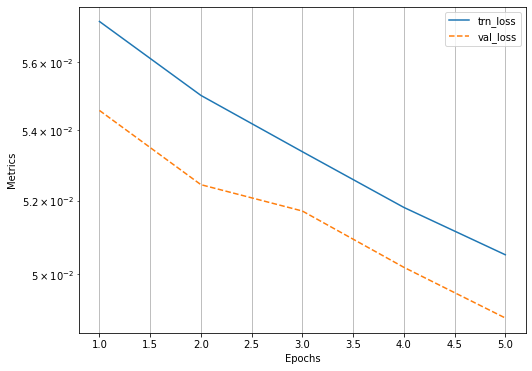

In [14]:

log.plot_epochs(log=True)

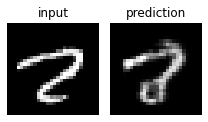

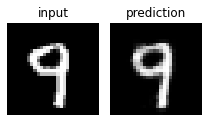

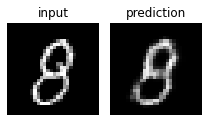

In [15]:
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

# **Grouping similar images using t-SNE**





In [16]:
latent_vectors = []
classes = []

In [17]:
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)

In [18]:
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

In [19]:
from sklearn.manifold import TSNE
tsne = TSNE(2)  # 2 means the dimension will convert in to 2 dimension


In [20]:
clustered =   tsne.fit_transform(latent_vectors)


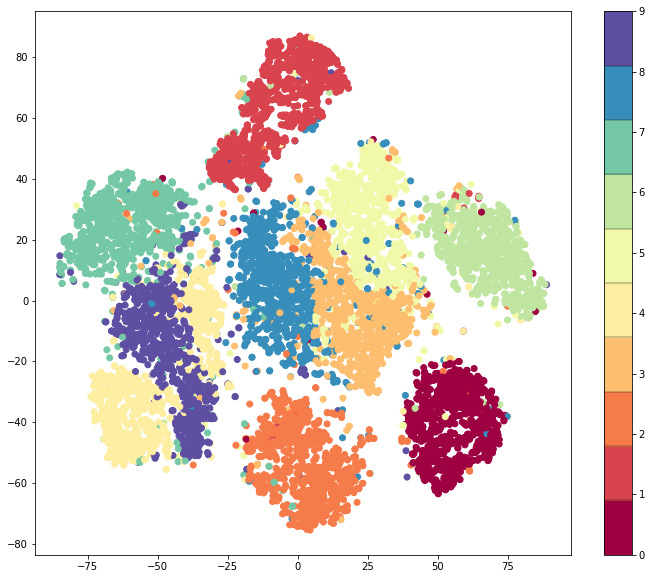

In [21]:
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)

In [22]:
latent_vectors = []
classes = []
for im,clss in val_dl:
    latent_vectors.append(model.encoder(im))
    classes.extend(clss)

latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy().reshape(10000, -1)


In [23]:
rand_vectors = []
for col in latent_vectors.transpose(1,0):
    mu,sigma = col.mean(), col.std()
    rand_vectors.append(sigma*torch.randn(1,100)+ mu)

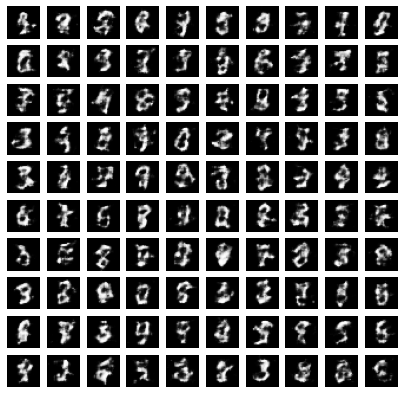

In [24]:
rand_vectors = torch.cat(rand_vectors).transpose(1,0).to(device)
fig, ax = plt.subplots(10,10,figsize=(7,7)); ax = iter(ax.flat)
for p in rand_vectors:
    img = model.decoder(p.reshape(1,64,2,2)).view(28,28)
    show(img, ax=next(ax))